In [167]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("using", device)

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed(777)

using cuda


In [168]:
batch_size = 256
noise_dim = 100
cont_dim = 10
dist_dim = 4
c_weight = 0.5

epoch = 500

test_len = 10
test_num = 50

lr_G = 0.0002
lr_D = 0.0002
k = 1

In [169]:
mnist_train = torchvision.datasets.MNIST(
    root = '../MNIST_data',
    train = True, 
    transform = torchvision.transforms.ToTensor(), 
    download = True
)
"""
mnist_test = torchvision.datasets.MNIST(
    root = '../MNIST_data', 
    train = False, 
    transform = torchvision.transforms.ToTensor(), 
    download = True
)
"""

"\nmnist_test = torchvision.datasets.MNIST(\n    root = '../MNIST_data', \n    train = False, \n    transform = torchvision.transforms.ToTensor(), \n    download = True\n)\n"

In [170]:
data_loader = torch.utils.data.DataLoader(
    dataset = mnist_train,
    shuffle = True,
    batch_size = batch_size,
    drop_last = True,
)

In [171]:
class discriminator(torch.nn.Module): # 28x28 size inputs -> true/false(classification)
    def __init__(self, noisedim) -> None:
        super().__init__()
        self.noisedim = noisedim
        self.act = torch.nn.LeakyReLU(0.2)
        self.conv1 = torch.nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(256)
        self.conv4 = torch.nn.Conv2d(256, 1 + noisedim, 4, 1, 0, bias=False)
        self.sig = torch.nn.Sigmoid()
        
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.act(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.act(out)

        out = self.conv4(out)
        out = self.sig(out)
  
        out = out.view(-1, 1 + self.noisedim)
        return out


In [172]:
class generator(torch.nn.Module): # 28x28 size inputs -> true/false(classification)
    def __init__(self, noisedim) -> None:
        super().__init__()
        self.noisedim = noisedim
        
        self.act = torch.nn.ReLU()
        self.conv1 = torch.nn.ConvTranspose2d(noisedim, 256, 4, 1, 0, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(256)
        self.conv2 = torch.nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)
        self.Tanh = torch.nn.Tanh()
        
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.act(out)

        out = self.conv4(out)
        out = self.Tanh(out)

        return out


In [173]:
def generate_cont(noisenum, contdim):
    return torch.randn(noisenum, contdim, 1, 1, device=device) + 0.5

In [174]:
def generate_dist_vector(noisenum, distdim):
    return torch.randint(0, distdim, size = (noisenum,), device=device)

In [175]:
def generate_dist(dist_np, distdim):
    return torch.nn.functional.one_hot(dist_np, num_classes = distdim).to(device).float().view(-1, distdim, 1, 1)

In [176]:
def generate_noise(noisenum, noisedim):
    return torch.randn(noisenum, noisedim, 1, 1, device=device)

In [177]:
def generate_labels(labelnum):
    return torch.zeros(labelnum, device=device), torch.ones(labelnum, device=device)

In [178]:
G = generator(noise_dim + cont_dim + dist_dim).to(device) #generator
D = discriminator(cont_dim + dist_dim).to(device) #discriminator
criterion = torch.nn.BCELoss()
crit_dist = torch.nn.CrossEntropyLoss()
G_optim = torch.optim.Adam(G.parameters(), lr = lr_G)
D_optim = torch.optim.Adam(D.parameters(), lr = lr_D)

cont_noise = generate_cont(test_len, cont_dim)
dist_noise = generate_dist(generate_dist_vector(test_len, dist_dim), dist_dim)
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

fake_labels, real_labels = generate_labels(batch_size)
print_per = epoch / test_num
idx = 1
real_images_arr = []

for i, (image, label) in enumerate(data_loader):
    real_images_arr.append(image.to(device).view(-1, 1, 28, 28))

EPOCH : 1 GLOSS: 8.284274101257324 DLOSS: 1.1911587715148926


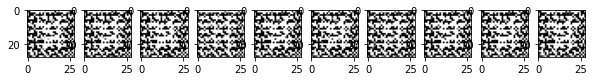

KeyboardInterrupt: 

In [179]:


for i in range(epoch):
    for real_images in real_images_arr:

        cont_noise = generate_cont(batch_size, cont_dim)
        dist_noise = generate_dist(generate_dist_vector(batch_size, dist_dim), dist_dim)
        
        random_noises = torch.cat([cont_noise, dist_noise, generate_noise(batch_size, noise_dim)], dim=1)
        fake_images = G(random_noises)
        real_outs = D(real_images)
        fake_outs = D(fake_images)

        fake_out_cc = fake_outs[:, 1:1 + cont_dim]
        fake_out_dc = fake_outs[:, 1 + cont_dim:]
        
        D_loss = criterion(real_outs[:, 0], real_labels) + \
            criterion(fake_outs[:, 0], fake_labels) + c_weight * crit_dist(fake_out_dc, dist_noise.view(batch_size, -1)) + \
            c_weight * torch.mean((fake_out_cc - cont_noise) * (fake_out_cc - cont_noise))
        
        D_optim.zero_grad()
        G_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        fake_images = G(random_noises)
        fake_outs = D(fake_images)
        fake_out_cc = fake_outs[:, 1:1 + cont_dim]
        fake_out_dc = fake_outs[:, 1 + cont_dim:]

        
        G_loss = criterion(fake_outs[:, 0], real_labels) + c_weight * crit_dist(fake_out_dc, dist_noise.view(batch_size, -1)) +\
            c_weight * torch.mean((fake_out_cc - cont_noise) * (fake_out_cc - cont_noise))

        D_optim.zero_grad()
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

    print("EPOCH :", i + 1, "GLOSS:", G_loss.item(), "DLOSS:", D_loss.item())

    if i % print_per == 0:
        generated_images = G(noise_for_print).view(test_len, 28, 28)
        plt.figure(figsize = (10, 100))
        for j in range(test_len):
            plt.subplot(1, test_len, j + 1)
            idx = idx + 1
            plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
        plt.show()

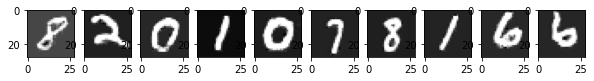

In [ ]:
noise_for_print = generate_noise(test_len, noise_dim)
generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()